# 전국 도시 공원 표준 데이터
https://www.data.go.kr/dataset/15012890/standard.do

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

In [3]:
%ls data

상가업소_201709/
상가업소_201709.zip
상권별_업종밀집통계_2016_.csv
서울특별시_자치구별_상권분석_정보_2017_.csv
전국도시공원표준데이터.csv


In [4]:
park = pd.read_csv('data/전국도시공원표준데이터.csv', encoding='euc-kr')
park.shape

(13135, 18)

In [5]:
park.head()

,관리번호,공원명,공원구분,소재지도로명주소,소재지지번주소,위도,경도,공원면적,공원보유시설(운동시설),공원보유시설(유희시설),공원보유시설(편익시설),공원보유시설(교양시설),공원보유시설(기타시설),지정고시일,관리기관명,전화번호,데이터기준일자,Unnamed: 17
0,42800-00001,상리공원,어린이공원,강원도 양구군 양구읍 상리 531,강원도 양구군 양구읍 상리 531,38.105771,127.985895,1597,NaN,NaN,NaN,NaN,NaN,1995-12-27,강원도 양구군청,033-480-2927,2018-02-28,NaN
1,42800-00002,정림공원1,어린이공원,강원도 양구군 양구읍 상리 587,강원도 양구군 양구읍 상리 587,38.104065,127.984467,1498,NaN,NaN,NaN,NaN,NaN,2009-09-25,강원도 양구군청,033-480-2927,2018-02-28,NaN
2,42800-00003,정림공원2,어린이공원,강원도 양구군 양구읍 상리 604-6,강원도 양구군 양구읍 상리 604-6,38.104065,127.984467,1499,NaN,NaN,NaN,NaN,NaN,2009-09-25,강원도 양구군청,033-480-2927,2018-02-28,NaN
3,42800-00004,하리수변공원,수변공원,강원도 양구군 양구읍 하리 643,강원도 양구군 양구읍 하리 643,38.118243,127.981634,18437,NaN,NaN,NaN,NaN,NaN,2010-03-19,강원도 양구군청,033-480-2460,2018-02-28,NaN
4,42800-00005,묘지공원,묘지공원,강원도 양구군 양구읍 죽곡리 산3-1,강원도 양구군 양구읍 죽곡리 산3-1,38.125344,127.999027,178931,NaN,NaN,NaN,NaN,NaN,2010-10-01,강원도 양구군청,033-480-2576,2018-02-28,NaN


In [6]:
from plotnine import *

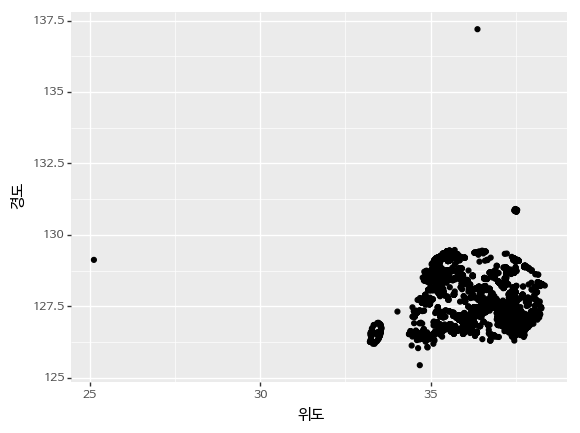

<ggplot: (-9223372036564435908)>

In [7]:
# 지도를 출력해 보니 특정 지역만 있는거 같다.
(ggplot(park)
 + aes(x='위도', y='경도')
 + geom_point()
 + theme(text=element_text(family='NanumBarunGothic'))
)

In [8]:
park['도'] = park['소재지도로명주소'].str.split(' ', expand=True)[0]
park.head()

,관리번호,공원명,공원구분,소재지도로명주소,소재지지번주소,위도,경도,공원면적,공원보유시설(운동시설),공원보유시설(유희시설),공원보유시설(편익시설),공원보유시설(교양시설),공원보유시설(기타시설),지정고시일,관리기관명,전화번호,데이터기준일자,Unnamed: 17,도
0,42800-00001,상리공원,어린이공원,강원도 양구군 양구읍 상리 531,강원도 양구군 양구읍 상리 531,38.105771,127.985895,1597,NaN,NaN,NaN,NaN,NaN,1995-12-27,강원도 양구군청,033-480-2927,2018-02-28,NaN,강원도
1,42800-00002,정림공원1,어린이공원,강원도 양구군 양구읍 상리 587,강원도 양구군 양구읍 상리 587,38.104065,127.984467,1498,NaN,NaN,NaN,NaN,NaN,2009-09-25,강원도 양구군청,033-480-2927,2018-02-28,NaN,강원도
2,42800-00003,정림공원2,어린이공원,강원도 양구군 양구읍 상리 604-6,강원도 양구군 양구읍 상리 604-6,38.104065,127.984467,1499,NaN,NaN,NaN,NaN,NaN,2009-09-25,강원도 양구군청,033-480-2927,2018-02-28,NaN,강원도
3,42800-00004,하리수변공원,수변공원,강원도 양구군 양구읍 하리 643,강원도 양구군 양구읍 하리 643,38.118243,127.981634,18437,NaN,NaN,NaN,NaN,NaN,2010-03-19,강원도 양구군청,033-480-2460,2018-02-28,NaN,강원도
4,42800-00005,묘지공원,묘지공원,강원도 양구군 양구읍 죽곡리 산3-1,강원도 양구군 양구읍 죽곡리 산3-1,38.125344,127.999027,178931,NaN,NaN,NaN,NaN,NaN,2010-10-01,강원도 양구군청,033-480-2576,2018-02-28,NaN,강원도


In [9]:
park_do = park['도'].value_counts()
park_do = park_do.reset_index()
park_do.columns = ['도', '합계']
park_do.sort_values(['합계'], ascending=False)

,도,합계
0,경기도,2178
1,전라북도,779
2,서울특별시,657
3,울산광역시,656
4,경상남도,458
5,강원도,411
6,전라남도,381
7,경상북도,243
8,대전광역시,231
9,인천광역시,207


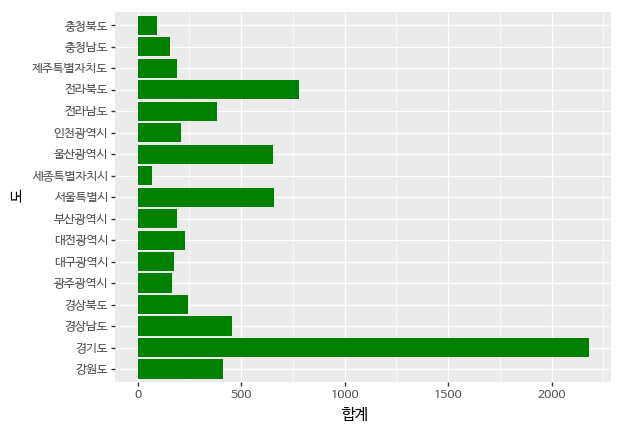

<ggplot: (-9223372036563910568)>

In [10]:
(ggplot(park_do)
 + aes(x='도', y='합계')
 + geom_bar(stat='identity', position='dodge', fill='green')
 + coord_flip()
 + theme(text=element_text(family='NanumBarunGothic'))
)